<a href="https://colab.research.google.com/github/patelkanak23/Urban-Sound-Classification/blob/main/Preprocessing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
import os
import tarfile
import re
import nltk
import xml.etree.ElementTree as ET
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
from datasets import Dataset
import evaluate
from transformers import EarlyStoppingCallback
from sklearn.metrics.pairwise import cosine_similarity
import random

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

# Extract tar file
def extract_tar_file(tar_file_path, extract_to_folder):
    """Extracts .tar or .tar.bz2 files."""
    if not os.path.isfile(tar_file_path):
        raise FileNotFoundError(f"File not found: {tar_file_path}")
    with tarfile.open(tar_file_path, "r:*") as tar:
        tar.extractall(path=extract_to_folder)
    print(f"Files extracted to: {extract_to_folder}")

# Preprocess text by cleaning, tokenizing, removing stopwords, and lemmatizing
def preprocess_text(text):
    """Cleans text by removing non-alphabetic characters, tokenizing, removing stopwords, and lemmatizing."""
    if text is None:
        return ''

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Parse extracted folder to extract bug report texts and labels
def parse_extracted_folder(folder_path):
    """Parses XML bug reports, extracts descriptions, and preprocesses them."""
    if not os.path.isdir(folder_path):
        raise NotADirectoryError(f"Directory not found: {folder_path}")

    all_texts, all_labels = [], []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xml"):
            file_path = os.path.join(folder_path, file_name)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                for bug in root.findall('bug'):
                    short_desc = bug.find('short_desc').text if bug.find('short_desc') else ''
                    processed_text = preprocess_text(short_desc)
                    all_texts.append(processed_text)
                    all_labels.append(1)  # Label for bug-related sentences

            except ET.ParseError as e:
                print(f"Error parsing XML file {file_name}: {e}")

    return all_texts, all_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Fine-tune the model with the extracted and preprocessed data
def fine_tune_model_with_targeted_negatives(texts, labels, output_model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define accuracy metric using evaluate
    accuracy_metric = evaluate.load("accuracy")

    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if os.path.exists(output_model_path) and os.listdir(output_model_path):
        print(f"Loading existing model from {output_model_path}")
        model = AutoModelForSequenceClassification.from_pretrained(output_model_path)
    else:
        print("No existing model found. Loading base model for fine-tuning.")
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    model.to(device)

    # Tokenizer function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding=True,
            return_attention_mask=True
        )

    # Generate targeted negatives (dissimilar sentences, but contextually valid)
    unrelated_texts = [
        "The stock market is volatile today.",
        "I love reading science fiction novels.",
        "The weather is changing rapidly across the country."
    ]

    # Introduce hard negatives by selecting sentences that are not directly related
    unrelated_texts = random.sample(unrelated_texts, 3)
    texts.extend(unrelated_texts)
    labels.extend([0] * len(unrelated_texts))  # Assign label 0 for unrelated sentences

    dataset = Dataset.from_dict({"text": texts, "label": labels})
    dataset = dataset.map(tokenize_function, batched=True)
    train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()

    # Custom compute_metrics function to calculate accuracy
    def compute_metrics(p):
        logits, labels = p
        predictions = np.argmax(logits, axis=-1)
        return accuracy_metric.compute(predictions=predictions, references=labels)

    # Training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=8,
        weight_decay=0.02,
        save_total_limit=3,
        logging_dir="./logs",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        warmup_ratio=0.1,
        gradient_accumulation_steps=4,
        report_to="none",
        fp16=True
    )

    # Trainer setup with EarlyStopping callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics
    )

    trainer.train()
    model.save_pretrained(output_model_path)
    tokenizer.save_pretrained(output_model_path)
    print(f"Model saved to {output_model_path}")

# Main flow to extract, process, and fine-tune
tar_file_path = "/content/freedesktop.tar.bz2"
output_folder = "/content/sample_data/ext"

# Step 1: Extract tar file
extract_tar_file(tar_file_path, output_folder)

# Step 2: Parse the extracted XML files to get texts and labels
texts, labels = parse_extracted_folder(output_folder)

# Step 3: Fine-tune the model with the prepared data
output_model_path = "/content/sample_data/sem_model_3"
fine_tune_model_with_targeted_negatives(texts, labels, output_model_path)


Files extracted to: /content/sample_data/ext
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No existing model found. Loading base model for fine-tuning.


Map:   0%|          | 0/106068 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-3a313cb1010b>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.003400,0.000717,0.999953
2,0.000800,0.000186,0.999953
3,0.000400,0.000105,0.999953
4,0.000200,0.000075,1.000000
5,0.000200,0.000059,1.000000
6,0.000100,0.000050,1.000000
7,0.000100,0.000040,1.000000


Model saved to /content/sample_data/sem_model_3


In [ ]:
!zip -r fine_tune_sem_model.zip /content/sample_data/sem_model_3


  adding: content/sample_data/sem_model_3/ (stored 0%)
  adding: content/sample_data/sem_model_3/vocab.txt (deflated 53%)
  adding: content/sample_data/sem_model_3/config.json (deflated 48%)
  adding: content/sample_data/sem_model_3/special_tokens_map.json (deflated 80%)
  adding: content/sample_data/sem_model_3/model.safetensors (deflated 8%)
  adding: content/sample_data/sem_model_3/tokenizer.json (deflated 71%)
  adding: content/sample_data/sem_model_3/tokenizer_config.json (deflated 73%)


In [ ]:
from google.colab import files
files.download('fine_tune_sem_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the model and tokenizer manually
model_path = "/content/sample_data/sem_model_3"
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Define sentences
sentence1 = "The application crashes when I open it."
sentence2 = "The app fails to load upon startup."
sentence3 = "The weather is sunny today."

# Tokenize the input sentences
inputs = tokenizer([sentence1, sentence2, sentence3], padding=True, truncation=True, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract embeddings (usually from the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

print(embeddings.shape)  # Should print [3, hidden_size]


torch.Size([3, 384])


In [ ]:
import numpy as np
embeddings_np = embeddings.cpu().numpy()
print(embeddings_np.shape)  # Should output (3, 384)


(3, 384)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_np)
print(similarity_matrix)


[[ 1.0000004   0.6271268  -0.01044002]
 [ 0.6271268   0.9999999  -0.01685898]
 [-0.01044002 -0.01685898  0.9999997 ]]


In [ ]:
import os
import tarfile
import re
import nltk
import xml.etree.ElementTree as ET
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
from datasets import Dataset
import evaluate
from transformers import EarlyStoppingCallback
from sklearn.metrics.pairwise import cosine_similarity
import random

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

def extract_tar_file(tar_file_path, extract_to_folder):
    """Extracts .tar or .tar.bz2 files."""
    if not os.path.isfile(tar_file_path):
        raise FileNotFoundError(f"File not found: {tar_file_path}")
    with tarfile.open(tar_file_path, "r:*") as tar:
        tar.extractall(path=extract_to_folder)
    print(f"Files extracted to: {extract_to_folder}")

def preprocess_text(text):
    """Cleans text by removing non-alphabetic characters, tokenizing, removing stopwords, and lemmatizing."""
    if text is None:
        return ''

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def generate_domain_specific_negatives(bug_texts, n_samples=100):
    """Generate domain-specific non-bug sentences that are technically focused."""
    tech_templates = [
        "The system is running smoothly with {} performance.",
        "Successfully deployed the new {} feature.",
        "The {} module is working as expected.",
        "Completed the {} integration successfully.",
        "The {} metrics show optimal results."
    ]

    # Extract technical terms from bug reports
    tech_terms = set()
    for text in bug_texts:
        words = text.split()
        tech_terms.update([w for w in words if len(w) > 3])

    negatives = []
    for _ in range(n_samples):
        template = random.choice(tech_templates)
        term = random.choice(list(tech_terms)) if tech_terms else "system"
        negatives.append(template.format(term))

    return negatives

def parse_extracted_folder(folder_path):
    """Parses XML bug reports, extracts descriptions, and preprocesses them."""
    if not os.path.isdir(folder_path):
        raise NotADirectoryError(f"Directory not found: {folder_path}")

    all_texts, all_labels = [], []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xml"):
            file_path = os.path.join(folder_path, file_name)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                for bug in root.findall('bug'):
                    short_desc = bug.find('short_desc').text if bug.find('short_desc') else ''
                    processed_text = preprocess_text(short_desc)
                    all_texts.append(processed_text)
                    all_labels.append(1)  # Label for bug-related sentences

            except ET.ParseError as e:
                print(f"Error parsing XML file {file_name}: {e}")

    return all_texts, all_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def fine_tune_model_with_targeted_negatives(texts, labels, output_model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define accuracy metric using evaluate
    accuracy_metric = evaluate.load("accuracy")

    model_name = "microsoft/deberta-v3-small"  # Using DeBERTa model for better performance
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if os.path.exists(output_model_path) and os.listdir(output_model_path):
        print(f"Loading existing model from {output_model_path}")
        model = AutoModelForSequenceClassification.from_pretrained(output_model_path)
    else:
        print("No existing model found. Loading base model for fine-tuning.")
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    model.to(device)

    # Tokenizer function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding=True,
            return_attention_mask=True
        )

    # Generate domain-specific negatives
    negative_samples = generate_domain_specific_negatives(texts)
    texts.extend(negative_samples)
    labels.extend([0] * len(negative_samples))  # Assign label 0 for unrelated sentences

    dataset = Dataset.from_dict({"text": texts, "label": labels})
    dataset = dataset.map(tokenize_function, batched=True)
    train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()

    # Custom compute_metrics function to calculate accuracy
    def compute_metrics(p):
        logits, labels = p
        predictions = np.argmax(logits, axis=-1)
        return accuracy_metric.compute(predictions=predictions, references=labels)

    # Training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=8,
        weight_decay=0.02,
        save_total_limit=3,
        logging_dir="./logs",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        warmup_ratio=0.1,
        gradient_accumulation_steps=4,
        report_to="none",
        fp16=True
    )

    # Trainer setup with EarlyStopping callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics
    )

    trainer.train()
    model.save_pretrained(output_model_path)
    tokenizer.save_pretrained(output_model_path)
    print(f"Model saved to {output_model_path}")

def calculate_semantic_similarity(model, tokenizer, sentences):
    """Calculate enhanced semantic similarity between sentences."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Get embeddings for each sentence
    embeddings = []
    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)

            # Use the average of the last hidden state for better representation
            last_hidden_state = outputs.hidden_states[-1]
            sentence_embedding = torch.mean(last_hidden_state, dim=1)
            embeddings.append(sentence_embedding.cpu().numpy())

    # Calculate cosine similarity matrix
    embeddings = np.vstack(embeddings)
    similarity_matrix = cosine_similarity(embeddings)

    return similarity_matrix

# Main flow to extract, process, and fine-tune
tar_file_path = "/content/freedesktop.tar.bz2"
output_folder = "/content/sample_data/extra"

# Step 1: Extract tar file
extract_tar_file(tar_file_path, output_folder)

# Step 2: Parse the extracted XML files to get texts and labels
texts, labels = parse_extracted_folder(output_folder)

# Step 3: Fine-tune the model with the prepared data
output_model_path = "/content/sample_data/sem_model_4"
fine_tune_model_with_targeted_negatives(texts, labels, output_model_path)

# Usage example for semantic similarity calculation
test_sentences = [
    "The application crashes when I open it.",
    "The app fails to load upon startup.",
    "The weather is sunny today."
]

similarity_matrix = calculate_semantic_similarity(model, tokenizer, test_sentences)
print("Enhanced Similarity Matrix:")
print(similarity_matrix)

Files extracted to: /content/sample_data/extra
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

No existing model found. Loading base model for fine-tuning.


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/106165 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-2-462d75231bfd>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000100,0.000008,1.000000
2,0.000000,0.000002,1.000000
3,0.000000,0.000001,1.000000
4,0.000000,0.000001,1.000000


Model saved to /content/sample_data/sem_model_4


NameError: name 'model' is not defined

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load the model and tokenizer manually
model_path = "/content/drive/MyDrive/deberta_model"
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Define sentences
sentence1 = "The app crashed on opening."
sentence2 = "The app fails to load upon startup may be kernel."
sentence3 = "The cricket is gentlemen's game."

# Tokenize the input sentences
inputs = tokenizer([sentence1, sentence2, sentence3], padding=True, truncation=True, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract embeddings (usually from the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

print(embeddings.shape)  # Should print [3, hidden_size]


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([3, 768])


In [ ]:
import numpy as np
embeddings_np = embeddings.cpu().numpy()
print(embeddings_np.shape)  # Should output (3, 384)


(3, 768)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_np)
print(similarity_matrix)


[[1.0000001  0.9689793  0.42976138]
 [0.9689793  1.0000001  0.43203542]
 [0.42976138 0.43203542 0.9999993 ]]


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy model to Google Drive
shutil.copytree("/content/sample_data/sem_model_3", "/content/drive/MyDrive/sem_model_3")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/sem_model_3'


🔍 Testing Model: /content/drive/MyDrive/fine_tune_sem_model
✅ Classification Metrics: {'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}


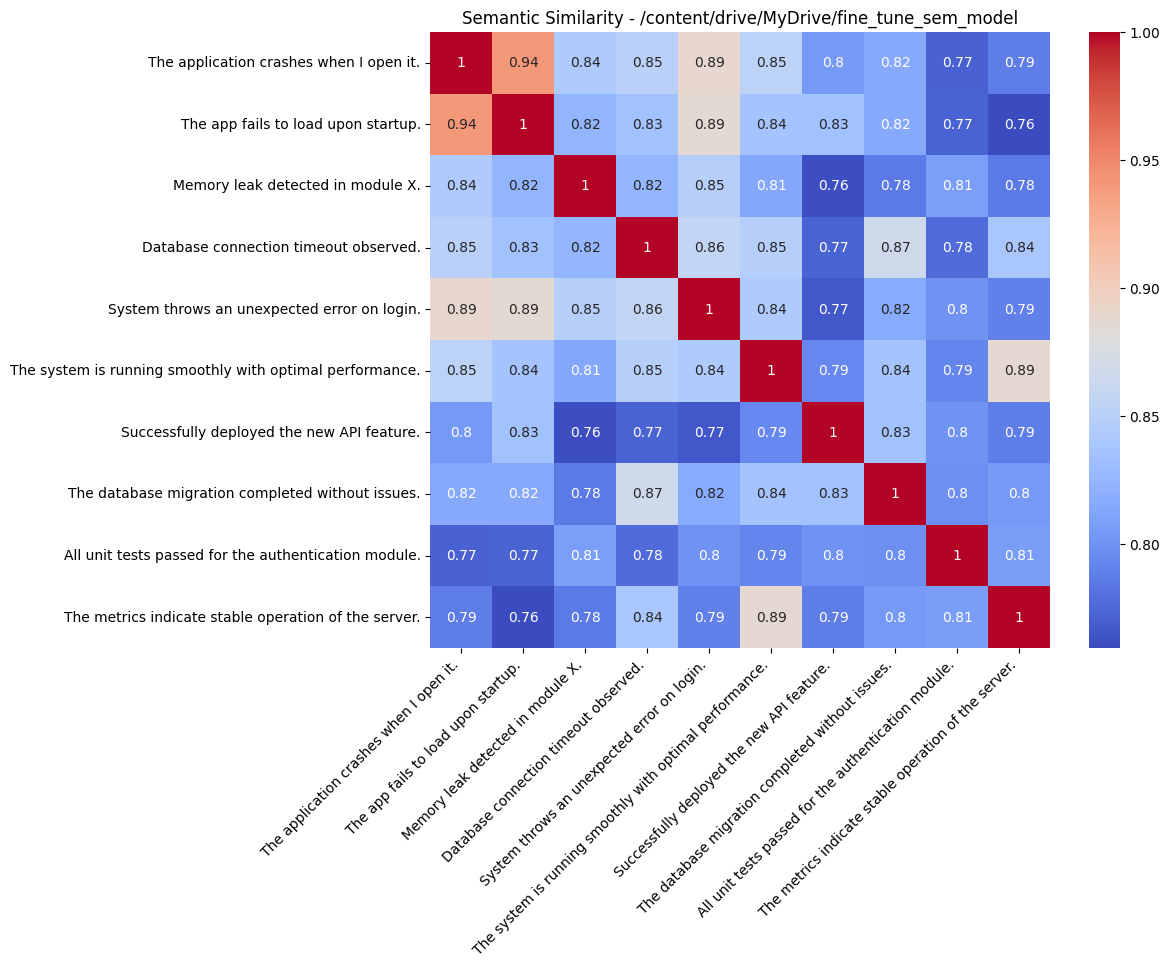


🔍 Testing Model: /content/drive/MyDrive/finetuned_sem_model2
✅ Classification Metrics: {'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}


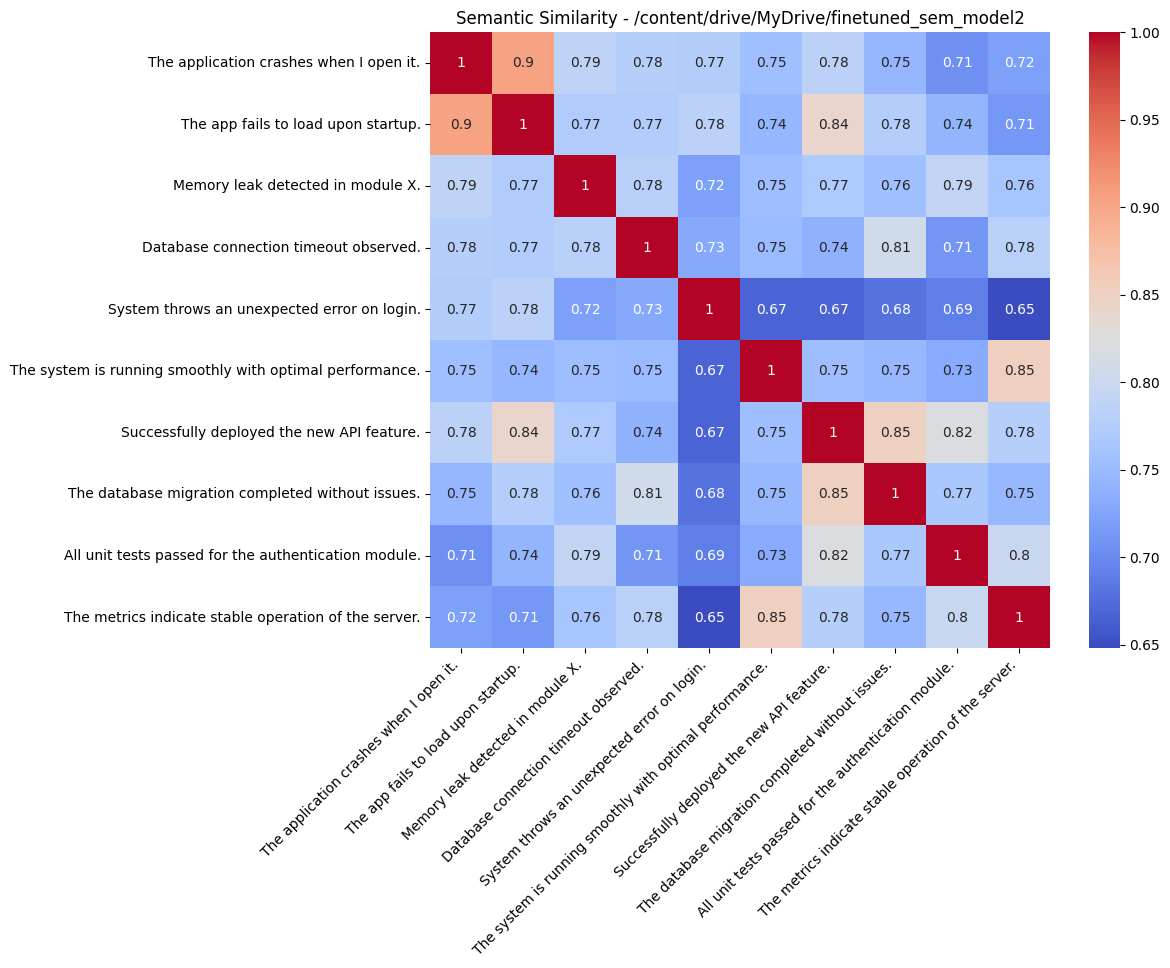


🔍 Testing Model: /content/drive/MyDrive/sem_model_3
✅ Classification Metrics: {'accuracy': 0.7, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693}


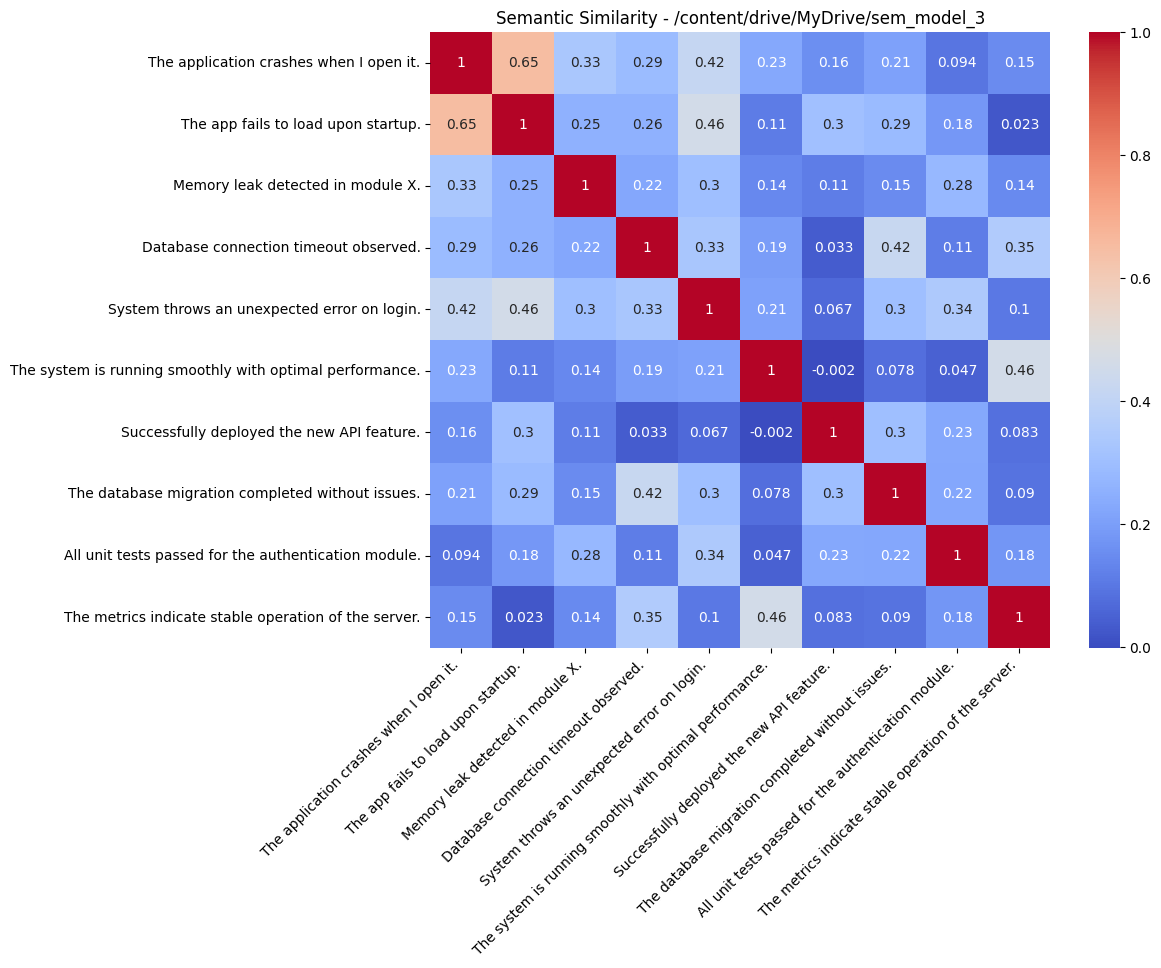


🔍 Testing Model: /content/drive/MyDrive/deberta_model


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ Classification Metrics: {'accuracy': 0.6, 'precision': 1.0, 'recall': 0.2, 'f1': 0.3333333333333333}


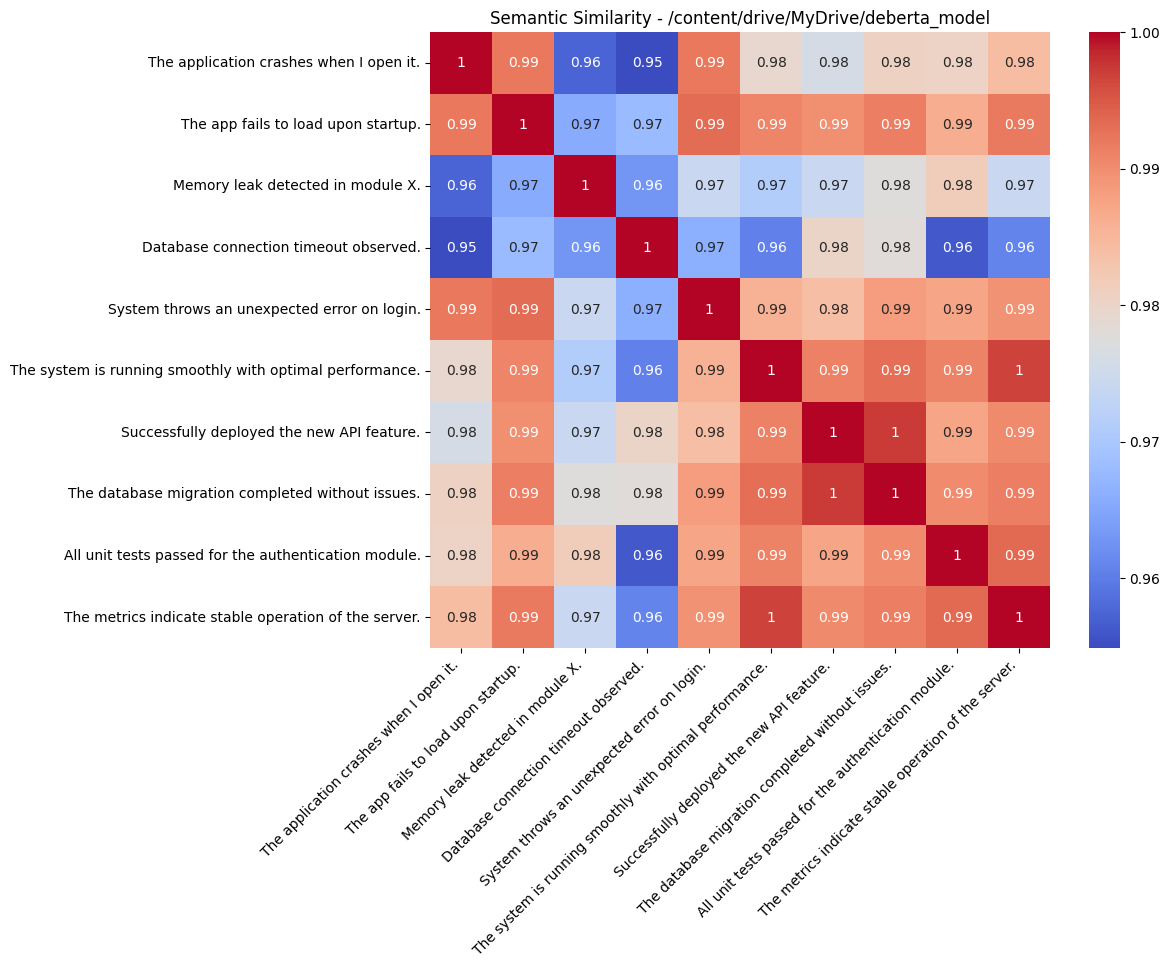


📌 Model: /content/drive/MyDrive/fine_tune_sem_model
📊 Metrics: {'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}

📌 Model: /content/drive/MyDrive/finetuned_sem_model2
📊 Metrics: {'accuracy': 0.5, 'precision': 0.5, 'recall': 1.0, 'f1': 0.6666666666666666}

📌 Model: /content/drive/MyDrive/sem_model_3
📊 Metrics: {'accuracy': 0.7, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693}

📌 Model: /content/drive/MyDrive/deberta_model
📊 Metrics: {'accuracy': 0.6, 'precision': 1.0, 'recall': 0.2, 'f1': 0.3333333333333333}


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# List of model paths to test
model_paths = [
    "/content/drive/MyDrive/fine_tune_sem_model",
    "/content/drive/MyDrive/finetuned_sem_model2",
    "/content/drive/MyDrive/sem_model_3",
    "/content/drive/MyDrive/deberta_model"
]

# Test sentences (Bug reports + Non-bug technical sentences)
test_sentences = [
    "The application crashes when I open it.",
    "The app fails to load upon startup.",
    "Memory leak detected in module X.",
    "Database connection timeout observed.",
    "System throws an unexpected error on login.",
    "The system is running smoothly with optimal performance.",
    "Successfully deployed the new API feature.",
    "The database migration completed without issues.",
    "All unit tests passed for the authentication module.",
    "The metrics indicate stable operation of the server."
]

# Labels: 1 for bugs, 0 for non-bugs
true_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

def load_model(model_path):
    """Load a model and tokenizer from a given path."""
    model = AutoModel.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

def compute_classification_metrics(model, tokenizer, sentences, true_labels):
    """Predict labels and compute classification metrics."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        logits = outputs.last_hidden_state.mean(dim=1)  # Mean pooling to get embeddings
        predicted_labels = (logits[:, 0] > 0).int().cpu().tolist()  # Binary classification assumption
        predictions.extend(predicted_labels)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

def calculate_semantic_similarity(model, tokenizer, sentences):
    """Compute semantic similarity between sentences using embeddings."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

    embeddings_np = embeddings.cpu().numpy()
    return cosine_similarity(embeddings_np)

# Iterate over all given models
results = {}
for model_path in model_paths:
    print(f"\n🔍 Testing Model: {model_path}")

    # Load model and tokenizer
    model, tokenizer = load_model(model_path)

    # Compute classification metrics
    metrics = compute_classification_metrics(model, tokenizer, test_sentences, true_labels)
    print("✅ Classification Metrics:", metrics)

    # Compute similarity matrix
    similarity_matrix = calculate_semantic_similarity(model, tokenizer, test_sentences)

    # Store results
    results[model_path] = {"metrics": metrics, "similarity_matrix": similarity_matrix}

    # Plot similarity heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", xticklabels=test_sentences, yticklabels=test_sentences)
    plt.title(f"Semantic Similarity - {model_path}")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# Compare results across models
for model_name, data in results.items():
    print(f"\n📌 Model: {model_name}")
    print("📊 Metrics:", data["metrics"])
